In [1]:
import pandas as pd
import numpy as np
import random
import math
import argparse
import time
import torch.nn.functional as F
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC,LinearSVC
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self, in_dim = 3, n_hidden = 10, n_layer = 3, out_dim = 3, drop_rate=0.1):
        super(LinearNetwork, self).__init__()
        self.layer1 = nn.Linear(in_dim, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden)
        self.layer4 = nn.Linear(n_hidden, n_hidden)
        self.layer5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, out_dim)
        self.drop_rate = drop_rate
        self.n_layer = n_layer

    def forward1(self, x):
        x = F.dropout(F.relu(self.layer1(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward3(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.dropout(F.relu(self.layer3(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward5(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.dropout(F.relu(self.layer5(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward(self, x):
        if self.n_layer == 1:
            return self.forward1(x)
        elif self.n_layer == 3:
            return self.forward3(x)
        elif self.n_layer == 5:
            return self.forward5(x)
        else:
            raise AssertionError

[Text(-4.0, 0, ''),
 Text(-3.0, 0, ''),
 Text(-2.0, 0, ''),
 Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, '')]

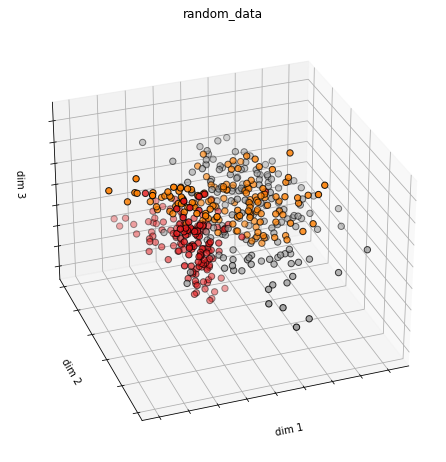

<ipython-input-3-bc10e13fb42c>:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


[Text(-0.8, 0, ''),
 Text(-0.6000000000000001, 0, ''),
 Text(-0.4, 0, ''),
 Text(-0.19999999999999996, 0, ''),
 Text(0.0, 0, ''),
 Text(0.19999999999999996, 0, ''),
 Text(0.40000000000000013, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.8, 0, ''),
 Text(1.0, 0, '')]

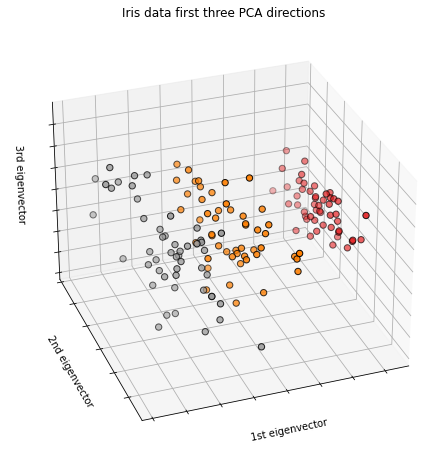

In [3]:
iris = datasets.load_iris()
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
y = iris.target

# 数据集可视化
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("Iris data first three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [4]:
def irisData_loader(x, y, batch_size = 30):

    random_data_idx = np.random.choice(50, 50, replace=False)
    X_train = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[:30],:].reshape(-1,3))
    X_val = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[30:40],:].reshape(-1,3))
    X_test = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[40:],:].reshape(-1,3))

    y = torch.LongTensor(y)
    y_train = y.reshape(3,50)[:,:30].reshape(-1)
    y_val = y.reshape(3,50)[:,30:40].reshape(-1)
    y_test = y.reshape(3,50)[:,40:].reshape(-1)
    
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
    loader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    return loader

def randomData_loader(x, y, batch_size = 5000):
    random_data_num = len(y)
    X_train = torch.Tensor(x[:int(random_data_num*0.9)])
    X_val = torch.Tensor(x[int(random_data_num*0.9):-int(random_data_num*0.05)])
    X_test = torch.Tensor(x[-int(random_data_num*0.05):])

    y = torch.LongTensor(y)
    y_train = y[:int(random_data_num*0.9)]
    y_val = y[int(random_data_num*0.9):-int(random_data_num*0.05)]
    y_test = y[-int(random_data_num*0.05):]
    
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
    loader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    return loader

np.random.seed(123)
loader = irisData_loader(X_reduced, y)
# loader_random = randomData_loader(random_data_x, random_data_y)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=1234)# 17 17 16

In [6]:
model_iris_3_10 = LinearNetwork().to(device)
model_iris_1_10 = LinearNetwork(n_layer = 1).to(device)
model_iris_5_10 = LinearNetwork(n_layer = 5).to(device)
model_iris_3_05 = LinearNetwork(n_hidden = 5).to(device)
model_iris_3_15 = LinearNetwork(n_hidden = 15).to(device)


In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

#     val_acc_history = []
    acc_history = {'train':[], 'val':[], 'test':[]}
    loss_history = {'train':[], 'val':[], 'test':[]}
    f1_history = {'train':[], 'val':[], 'test':[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            preds = np.array(preds.cpu())
            ytest = np.array(labels.data.cpu())
            epoch_f1 = metrics.f1_score(ytest, preds, zero_division=False, average='macro')
            acc_history[phase].append(np.array(epoch_acc.cpu()))
            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(epoch_f1)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history, f1_history

In [8]:
# iris
num_epochs = 500

params_to_update310 = model_iris_3_10.parameters()
params_to_update110 = model_iris_1_10.parameters()
params_to_update510 = model_iris_5_10.parameters()
params_to_update305 = model_iris_3_05.parameters()
params_to_update315 = model_iris_3_15.parameters()

optimizer_ft310 = optim.Adam(params_to_update310, lr=0.001)
optimizer_ft110 = optim.Adam(params_to_update110, lr=0.001)
optimizer_ft510 = optim.Adam(params_to_update510, lr=0.001)
optimizer_ft305 = optim.Adam(params_to_update305, lr=0.001)
optimizer_ft315 = optim.Adam(params_to_update315, lr=0.001)

criterion = nn.CrossEntropyLoss()

model_ft310, hist310, loss310, f1_310 = train_model(model_iris_3_10, loader, criterion, optimizer_ft310, num_epochs=num_epochs)
model_ft110, hist110, loss110, f1_110 = train_model(model_iris_1_10, loader, criterion, optimizer_ft110, num_epochs=num_epochs)
model_ft510, hist510, loss510, f1_510 = train_model(model_iris_5_10, loader, criterion, optimizer_ft510, num_epochs=num_epochs)
model_ft305, hist305, loss305, f1_305 = train_model(model_iris_3_05, loader, criterion, optimizer_ft305, num_epochs=num_epochs)
model_ft315, hist315, loss315, f1_315 = train_model(model_iris_3_15, loader, criterion, optimizer_ft315, num_epochs=num_epochs)

oss: 0.5531 Acc: 1.0000
test Loss: 0.6066 Acc: 0.9667
Epoch 327/499
----------
train Loss: 0.5690 Acc: 0.9889
val Loss: 0.5550 Acc: 1.0000
test Loss: 0.6156 Acc: 0.9667
Epoch 328/499
----------
train Loss: 0.5730 Acc: 0.9778
val Loss: 0.5525 Acc: 1.0000
test Loss: 0.5981 Acc: 0.9667
Epoch 329/499
----------
train Loss: 0.5685 Acc: 0.9889
val Loss: 0.5563 Acc: 1.0000
test Loss: 0.6312 Acc: 0.9333
Epoch 330/499
----------
train Loss: 0.5679 Acc: 0.9889
val Loss: 0.5533 Acc: 1.0000
test Loss: 0.6088 Acc: 0.9667
Epoch 331/499
----------
train Loss: 0.5664 Acc: 0.9889
val Loss: 0.5537 Acc: 1.0000
test Loss: 0.6140 Acc: 0.9333
Epoch 332/499
----------
train Loss: 0.5647 Acc: 0.9889
val Loss: 0.5573 Acc: 1.0000
test Loss: 0.6111 Acc: 0.9667
Epoch 333/499
----------
train Loss: 0.5666 Acc: 0.9889
val Loss: 0.5544 Acc: 1.0000
test Loss: 0.6230 Acc: 0.9000
Epoch 334/499
----------
train Loss: 0.5745 Acc: 0.9778
val Loss: 0.5536 Acc: 1.0000
test Loss: 0.6105 Acc: 0.9667
Epoch 335/499
----------
t

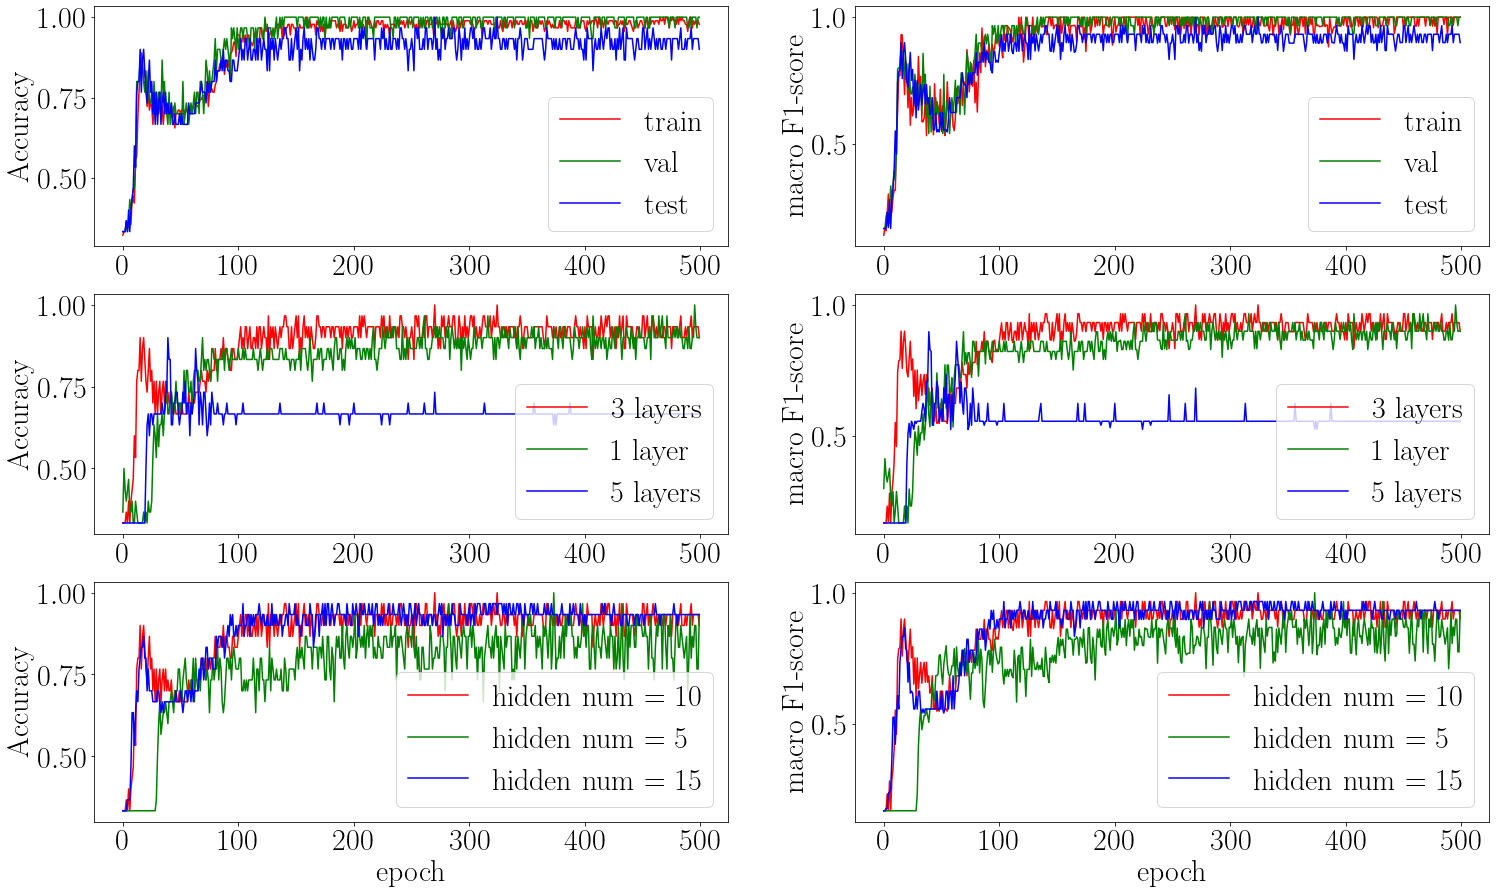

In [9]:
def draw3(hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315, num_epochs):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 15))

    plt.subplot(321)
    plt.plot(x, hist310['train'], 'r', label = 'train')
    plt.plot(x, hist310['val'], 'g', label = 'val')
    plt.plot(x, hist310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(322)
    plt.plot(x, f1_310['train'], 'r', label = 'train')
    plt.plot(x, f1_310['val'], 'g', label = 'val')
    plt.plot(x, f1_310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)

    plt.subplot(323)
    plt.plot(x, hist310['test'], 'r', label = '3 layers')
    plt.plot(x, hist110['test'], 'g', label = '1 layer')
    plt.plot(x, hist510['test'], 'b', label = '5 layers')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(324)
    plt.plot(x, f1_310['test'], 'r', label = '3 layers')
    plt.plot(x, f1_110['test'], 'g', label = '1 layer')
    plt.plot(x, f1_510['test'], 'b', label = '5 layers')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(325)
    plt.plot(x, hist310['test'], 'r', label = 'hidden num = 10')
    plt.plot(x, hist305['test'], 'g', label = 'hidden num = 5')
    plt.plot(x, hist315['test'], 'b', label = 'hidden num = 15')
    plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(326)
    plt.plot(x, f1_310['test'], 'r', label = 'hidden num = 10')
    plt.plot(x, f1_305['test'], 'g', label = 'hidden num = 5')
    plt.plot(x, f1_315['test'], 'b', label = 'hidden num = 15')
    plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)   
    
draw3(hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315, num_epochs)


In [10]:
iris_list = [hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315]
# random_list = [hist310r, hist110r, hist510r, hist305r, hist315r, f1_310r, f1_110r, f1_510r, f1_305r, f1_315r]

def all_f1(data_list):
#     data_list.cpu()
    max_list = []
    for j,i in enumerate(data_list[5:]):
        f1_max = np.mean(i['test'][-10:])
#         print(np.array(data_list[j]['test'])[-5:])
        acc_max = np.mean(np.array(data_list[j]['test'])[-10:])
        max_list.append([f1_max, acc_max])
#         f1_max = np.max(i['test'])
#         loc = np.where(i['test'] == f1_max)
#         acc_max = np.max(np.array(data_list[j]['test'])[loc])
#         max_list.append([f1_max, acc_max])
    return np.array(max_list)

iris_best = all_f1(iris_list)


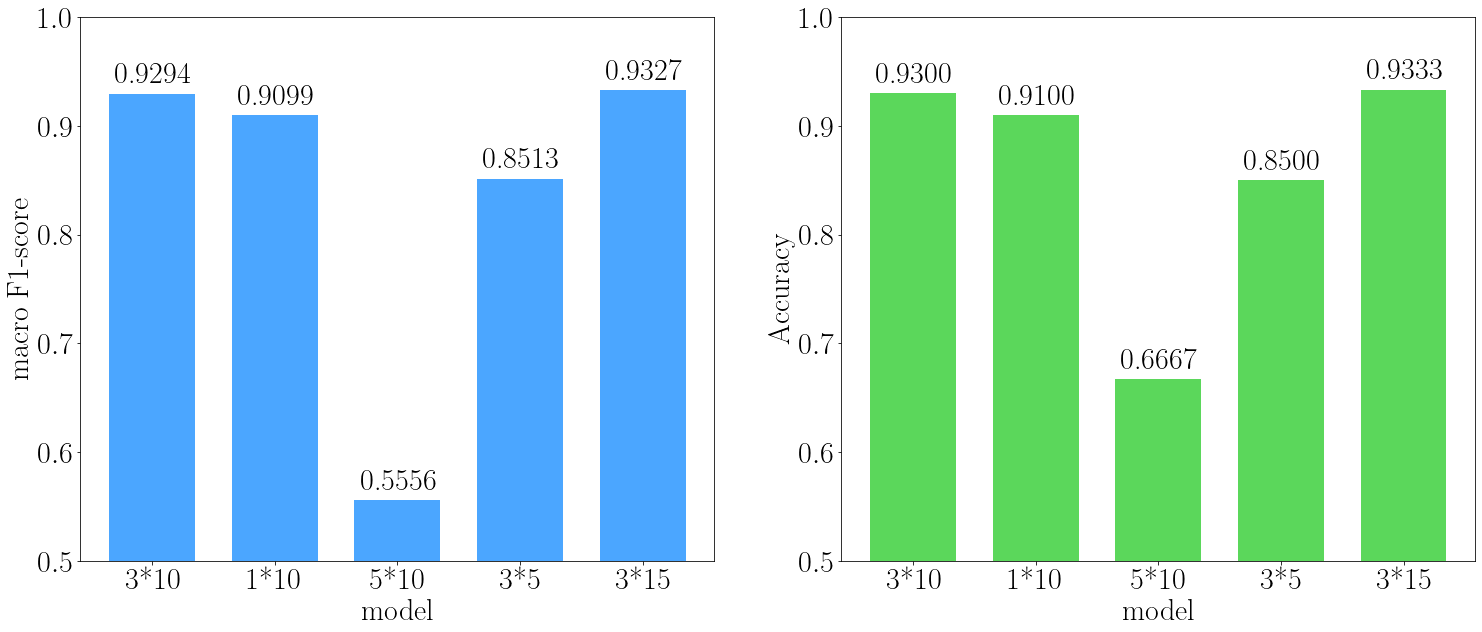

In [11]:
def draw_bar(data_list, num_epochs = 5):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 10))

    plt.subplot(121)
    plt.bar(range(5), data_list[:,0], width=0.7, color='dodgerblue', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("macro F1-score", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,0]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)

    
    plt.subplot(122)
    plt.bar(range(5), data_list[:,1], width=0.7, color='limegreen', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,1]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)

draw_bar(iris_best)
